In [1]:
import pandas as pd
from os.path import join
import category_encoders as ce
import re

In [2]:
data_path = join('dataset',  'wine_cleared.csv')

In [3]:
data = pd.read_csv(data_path, index_col='Unnamed: 0')

In [4]:
data.head()

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
data['price_round'] = data.price.round().astype('int')

Синтаксис регулярных выражений необычен и содержит различные символы, знаки препинания, математических операций и так далее. Подробнее ознакомиться с синтаксисом регулярных выражений поможет статья <a href="https://tproger.ru/translations/regular-expression-python/">Python RegEx: практическое применение регулярок</a>.

In [6]:
regex = '\d{4}'
data['year'] = data.title.str.findall(regex).str.get(0).astype('float') # Применяем float, чтобы не споткнуться на nan
data.year.isna().sum()

4609

Проверим, насколько надежен такой способ определения года производства вина.

Для начала взглянем на пропущенные значения:

In [7]:
data[data.year.isna()].title

63                Roland Champion NV Brut Rosé  (Champagne)
69                         Collet NV Brut Rosé  (Champagne)
237       Consorzio Vini Tipici di San Marino NV Moscato...
315       Bellussi NV Extra Dry  (Prosecco di Valdobbiad...
326       Marsuret NV Extra Dry  (Prosecco di Valdobbiad...
                                ...                        
129710         Molliver Vineyards NV Chambourcin (Virginia)
129719    Bruno Gobillard NV Domaine Vieilles Vignes Bru...
129743               Castelnau NV Réserve Brut  (Champagne)
129869       Biltmore Estate NV Brut Sparkling (California)
129929    Col Vetoraz Spumanti NV  Prosecco Superiore di...
Name: title, Length: 4609, dtype: object

Видим, что в таких наименованиях действительно отсутствуют числовые данные, в том числе похожие на год.

Гипотеза: вина, в названиях которых не указан год производства только что произведены. Поэтому заполнить пропуски можно будет максимальным значением  year.

Посмотрим на минимальное полученное значение года производства вина

In [8]:
data.year.min()

1000.0

Наблюдаем явную чушь. Посмотрим на то, как выглядят названия вин с годом производства меньше 1500-го:

In [9]:
data[data.year < 1500].title

3929             Don Cristobal 1492 2010 1492 Red (Mendoza)
16076     Don Cristobal 1492 2010 Finca La Niña Malbec (...
30001     1000 Stories 2013 Bourbon Barrel Aged Zinfande...
33110     Don Cristobal 1492 2010 Finca La Niña Cabernet...
48702     Don Cristobal 1492 2010 Finca La Niña Malbec (...
53228          1070 Green 2011 Sauvignon Blanc (Rutherford)
77996     1000 Stories 2014 Bourbon Barrel Aged Batch No...
82746        Cristobal 1492 2009 1492 White White (Mendoza)
83509                     Ikal 1150 2007 Malbec (Tupungato)
94395      Cristobal 1492 2007 Cabernet Sauvignon (Mendoza)
127114                Ikal 1150 2007 Chardonnay (Tupungato)
Name: title, dtype: object

Видим, что групп цифр в таких наименованиях несколько. Гипотеза: из групп по 4 цифры год обозначает максимальная. Проверим её, посмотрев на максимальное значение year.

In [10]:
data.year.max()

7200.0

И тут тоже наблюдаем явную чушь. 7200 год еще не скоро, а машину времени еще не изобрели. Посмотрим на названия вин для годов из будущего:

In [11]:
data[data.year > 2020].title

5346      Foxen 7200 2012 7200 Cabernet Sauvignon (Happy...
51320     Foxen 7200 2007 Vogelzang Vineyard Cabernet Sa...
67294     Foxen 7200 2012 Range 30 West Red (Happy Canyo...
77155     Foxen 7200 2015 Vogelzang Vineyard Sauvignon B...
89464     Foxen 7200 2012 7200 Grassini Family Vineyard ...
92740     Foxen 7200 2014 Vogelzang Vineyard Cabernet Sa...
95719     Foxen 7200 2012 Range 30 West Red (Happy Canyo...
97223     Foxen 7200 2012 7200 Vogelzang Vineyard Cabern...
99984     Foxen 7200 2008 Grassini Family Vineyard Caber...
101858    Foxen 7200 2007 Grassini Family Vineyard Caber...
101859    Foxen 7200 2008 Range 30 West Red (Happy Canyo...
105885             3000 BC 2009 Chenin Blanc (Stellenbosch)
108703    Foxen 7200 2014 Grassini Family Vineyard Caber...
109157    Foxen 7200 2013 7200 Vogelzang Vineyard Sauvig...
120445    Foxen 7200 2013 Vogelzang Vineyard Cabernet Sa...
Name: title, dtype: object

Проверить, насколько точно работает ваше регулярное выражение, а также найти реализацию популярных регулярных выражений (например, поиска номера телефона), вы сможете на сайте https://ihateregex.io.

Гипотеза не подтвердилась. Зато видим, что в таких названиях значения для определения года производства присутствуют.

Предлагаемый алгоритм выделения года:
1. Если групп из четырёх цифр вообще нет, то оставляем None, чтобы в дальнейшем заполнить максимальным значением года;
2. Если группа одна, проверяем её на вхождение в диапазон 1990 - 2020. Если не входит, возвращаем None;
3. Если групп несколько, берем ту, что входит в диапазон 1990-2020 и имеет максимальное значение.

In [12]:
regex = '\d{4}'
data[data.year > 2020].title.str.findall(regex)#.str #.get(0).astype('float') # Применяем float, чтобы не споткнуться на nan

5346      [7200, 2012, 7200]
51320           [7200, 2007]
67294           [7200, 2012]
77155           [7200, 2015]
89464     [7200, 2012, 7200]
92740           [7200, 2014]
95719           [7200, 2012]
97223     [7200, 2012, 7200]
99984           [7200, 2008]
101858          [7200, 2007]
101859          [7200, 2008]
105885          [3000, 2009]
108703          [7200, 2014]
109157    [7200, 2013, 7200]
120445          [7200, 2013]
Name: title, dtype: object

In [13]:
data.title.iloc[5346]

'Foxen 7200 2012 7200 Cabernet Sauvignon (Happy Canyon of Santa Barbara)'

In [14]:
def get_year(title: str) -> float:
    """
    Returns year from title of wines dataset like: 'Antichi Vinai 1877 2013 Pietralava Red (Etna)'

    Args:
        title (str): Title

    Returns:
        float: year
    """
    
    groups = re.findall(r'\d{4}', title)
    
    for group in groups:
        year = float(group)
        if 1990 <= year <= 2022:
            return year

    return None

In [15]:
data['year'] = data.title.map(get_year)

In [16]:
data['is_usa'] = (data.country == 'US').astype(int)

In [17]:
data.is_usa.head()

0    0
1    0
2    1
3    1
4    1
Name: is_usa, dtype: int64

### Задание 2.1
1 point possible (graded)

Выберите из списка две самых популярных (помимо США) страны, производящих вино.

In [18]:
data.country.value_counts()

US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4472
Argentina                  3800
Austria                    3345
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Israel                      505
Greece                      466
Canada                      257
Hungary                     146
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14
Serbia  

### Задание 2.2
2 points possible (graded)

Создайте бинарные признаки is_france, is_italy наподобие признака is_usa.

В ответ впишите результат выполнения кода data['is_france'].sum():

In [19]:
data['is_france'] = (data.country == 'France').astype(int)
data.is_france.sum()

22093

В ответ впишите результат выполнения кода data['is_italy'].sum():

In [20]:
data['is_italy'] = (data.country == 'Italy').astype(int)
data.is_italy.sum()

19540

### Задание 2.3
1 point possible (graded)

Создайте новый бинарный признак old_wine, где значение 1 будет обозначать, что вино старше 2010 года.

В ответ впишите результат выполнения кода data['old_wine'].sum():

In [21]:
max_year = data.year.max()
data.year.fillna(max_year, inplace=True)

In [22]:
data.year = data.year.astype('int')

In [23]:
data['old_wine'] = (data.year < 2010).astype('int')
data.old_wine.head()

0    0
1    0
2    0
3    0
4    0
Name: old_wine, dtype: int64

In [24]:
data.old_wine.sum()

39605

Итак, правильный ответ с учетом правильного выделения года производства из title: 39605

In [25]:
re.findall(r'\(\w+?\s?\w+?\s?\w+?\s?\w+?\s?\w+\)', 'Antichi Vinai 1877 2013 Pietralava Red (Etna Mallini Bandito Znamenito)')

['(Etna Mallini Bandito Znamenito)']

In [26]:
def get_locality(title: str) -> str:
    """
    Returns locality from title.
    get_valley('Antichi Vinai 1877 2013 Pietralava Red (Etna Mallini Bandito Znamenito)')
    will return Etna Mallini Bandito Znamenito

    Args:
        title (str): Wine title

    Returns:
        str: Locality or None
    """
    
    return found[0][1:-1] if (found := re.findall(r'\(.*?\)', title)) else None

In [27]:
get_locality('Antichi Vinai 1877 2013 Pietralava Red (Etna Mallini Bandito Znamenito)')

'Etna Mallini Bandito Znamenito'

In [28]:
data['locality'] = data.title.map(get_locality)
data.locality.isna().sum()

10522

In [29]:
data.title[data.locality.isna()]

65                            Simonnet-Febvre 2015  Chablis
66        Vignerons des Terres Secrètes 2015  Mâcon-Mill...
95                               Henry Fessy 2015  Juliénas
96                                 Henry Fessy 2015  Régnié
117                                Rideau 2014 Estate Syrah
                                ...                        
129875         Domaine des Nugues 2015  Beaujolais-Villages
129892             La Mannella 2012  Brunello di Montalcino
129900                                   Psagot 2014 Merlot
129929    Col Vetoraz Spumanti NV  Prosecco Superiore di...
129931            Henri de Villamont 2005  Grands-Echezeaux
Name: title, Length: 10522, dtype: object

In [30]:
cntry_pop_path = join('dataset', 'country_population.csv')

In [31]:
country_population = pd.read_csv(cntry_pop_path, sep=';')

country_population

,country,population
0,China,"1,411,778,724"
1,India,"1,386,584,581"
2,US,"333,022,386"
3,Indonesia,"271,350,000"
4,Pakistan,"225,200,000"
...,...,...
236,Niue,"1,549"
237,Tokelau,"1,501"
238,Vatican City,825
239,Cocos Islands,573


### Задание 3.1
1 point possible (graded)

Каково население Италии согласно датасету country_population? Ответ вводите без пробелов и запятых.

In [32]:
int(country_population[country_population.country == 'Italy'].population.values[0].replace(',', ''))

59097904

In [33]:
data = data.join(country_population.set_index('country'), on='country')

In [34]:
data

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,variety,winery,price_round,year,is_usa,is_france,is_italy,old_wine,locality,population
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,35,2013,0,0,1,0,Etna,"59,097,904"
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,15,2011,0,0,0,0,Douro,"10,347,892"
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,14,2013,1,0,0,0,Willamette Valley,"333,022,386"
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,13,2013,1,0,0,0,Lake Michigan Shore,"333,022,386"
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,65,2012,1,0,0,0,Willamette Valley,"333,022,386"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.000000,Mosel,unknown,Anna Lee C. Iijima,unknown,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),28,2013,0,0,0,0,Erben Müller-Burggraef,"83,129,285"
129967,US,Citation is given as much as a decade of bottl...,unknown,90,75.000000,Oregon,Oregon,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,75,2004,1,0,0,1,Oregon,"333,022,386"
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.000000,Alsace,Alsace,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,30,2013,0,1,0,0,Alsace,"68,035,000"
129969,France,"A dry style of Pinot Gris, this is crisp with ...",unknown,90,32.000000,Alsace,Alsace,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,32,2012,0,1,0,0,Alsace,"68,035,000"


In [35]:
data.population.isna().sum()

149

In [36]:
cntry_area_path = join('dataset', 'country_area.csv')
country_area = pd.read_csv(cntry_area_path, sep=';')
country_area.head()

,country,area
0,Russia,17075400.0
1,Canada,9984670.0
2,China,9596960.0
3,US,9372610.0
4,Brazil,8547000.0


In [37]:
data = data.join(country_area.set_index('country'), on='country')
data.area.isna().sum()

137

### Задание 3.2
1 point possible (graded)

Создайте новый признак area_country — площадь страны, аналогичный признаку country_population.

Какая площадь страны у вина под названием 'Gård 2014 Grand Klasse Reserve Lawrence Vineyards Viognier (Columbia Valley (WA))'? Ответ вводите без пробелов, округлите до целых.

In [38]:
int(data[data.title == 'Gård 2014 Grand Klasse Reserve Lawrence Vineyards Viognier (Columbia Valley (WA))'].area.values[0])

9372610

Давайте рассмотрим, из каких признаков состоит срез данных:

* client_id — идентификатор клиента в базе;
* agent_date — время соединения с агентом;
* created_at — время соединения с клиентом (начало разговора);
* end_date — время окончания соединения с клиентом (конец разговора).

In [39]:
# инициализируем информацию о звонках
calls_list = [
    [460, '2013-12-17 04:55:39', '2013-12-17 04:55:44', '2013-12-17 04:55:45'],
    [12, '2013-12-16 20:03:20', '2013-12-16 20:03:22', '2013-12-16 20:07:13'],
    [56, '2013-12-16 20:03:20', '2013-12-16 20:03:20', '2013-12-16 20:05:04'],
    [980, '2013-12-16 20:03:20','2013-12-16 20:03:27', '2013-12-16 20:03:29'],
    [396, '2013-12-16 20:08:27', '2013-12-16 20:08:28','2013-12-16 20:12:03'],
    [449, '2013-12-16 20:03:20', '2013-12-16 20:03:25','2013-12-16 20:05:00'],
    [397, '2013-12-16 20:08:25', '2013-12-16 20:08:27', '2013-12-16 20:09:59'],
    [398, '2013-12-16 20:01:23', '2013-12-16 20:01:23', '2013-12-16 20:04:58'],
    [452, '2013-12-16 20:03:20', '2013-12-16 20:03:21','2013-12-16 20:04:55'],
    [440, '2013-12-16 20:03:20', '2013-12-16 20:04:26', '2013-12-16 20:04:32']
]

calls = pd.DataFrame(calls_list, columns = ['client_id',  'agent_date', 'created_at' ,'end_date'])

# преобразовываем признаки в формат datetime для удобной работы

calls['agent_date'] = pd.to_datetime(calls['agent_date'])
calls['created_at'] = pd.to_datetime(calls['created_at'])
calls['end_date'] = pd.to_datetime(calls['end_date'])

calls

,client_id,agent_date,created_at,end_date
0,460,2013-12-17 04:55:39,2013-12-17 04:55:44,2013-12-17 04:55:45
1,12,2013-12-16 20:03:20,2013-12-16 20:03:22,2013-12-16 20:07:13
2,56,2013-12-16 20:03:20,2013-12-16 20:03:20,2013-12-16 20:05:04
3,980,2013-12-16 20:03:20,2013-12-16 20:03:27,2013-12-16 20:03:29
4,396,2013-12-16 20:08:27,2013-12-16 20:08:28,2013-12-16 20:12:03
5,449,2013-12-16 20:03:20,2013-12-16 20:03:25,2013-12-16 20:05:00
6,397,2013-12-16 20:08:25,2013-12-16 20:08:27,2013-12-16 20:09:59
7,398,2013-12-16 20:01:23,2013-12-16 20:01:23,2013-12-16 20:04:58
8,452,2013-12-16 20:03:20,2013-12-16 20:03:21,2013-12-16 20:04:55
9,440,2013-12-16 20:03:20,2013-12-16 20:04:26,2013-12-16 20:04:32


In [40]:
calls['duration'] = (calls['end_date'] - calls['created_at']).dt.seconds
calls

,client_id,agent_date,created_at,end_date,duration
0,460,2013-12-17 04:55:39,2013-12-17 04:55:44,2013-12-17 04:55:45,1
1,12,2013-12-16 20:03:20,2013-12-16 20:03:22,2013-12-16 20:07:13,231
2,56,2013-12-16 20:03:20,2013-12-16 20:03:20,2013-12-16 20:05:04,104
3,980,2013-12-16 20:03:20,2013-12-16 20:03:27,2013-12-16 20:03:29,2
4,396,2013-12-16 20:08:27,2013-12-16 20:08:28,2013-12-16 20:12:03,215
5,449,2013-12-16 20:03:20,2013-12-16 20:03:25,2013-12-16 20:05:00,95
6,397,2013-12-16 20:08:25,2013-12-16 20:08:27,2013-12-16 20:09:59,92
7,398,2013-12-16 20:01:23,2013-12-16 20:01:23,2013-12-16 20:04:58,215
8,452,2013-12-16 20:03:20,2013-12-16 20:03:21,2013-12-16 20:04:55,94
9,440,2013-12-16 20:03:20,2013-12-16 20:04:26,2013-12-16 20:04:32,6


### Задание 4.1
1 point possible (graded)

Подсчитайте, сколько секунд тратят сотрудники компании на дозвон клиенту. Результат запишите в новый признак time_connection.

В ответ запишите результат выполнения следующего кода: calls['time_connection'].sum().

In [41]:
calls['time_connection'] = (calls.created_at - calls.agent_date).dt.seconds
calls.time_connection.sum()

89

### Задание 4.2
1 point possible (graded)

Создайте новый признак is_connection — факт соединения с клиентом. Признак будет равен 1 в случае, если разговор состоялся и продлился больше 10 секунд, иначе — 0.

В ответ запишите результат выполнения следующего кода: calls['is_connection'].sum().

In [42]:
calls['is_connection'] = (calls.duration > 10).astype('int')
calls.is_connection.sum()

7

### Задание 4.3
1 point possible (graded)

Создайте признак time_diff — разницу в секундах между началом звонка(не разговора) и его окончанием.

В ответ запишите результат выполнения следующего кода: calls['time_diff'].sum().

In [43]:
calls['time_diff'] = (calls.end_date - calls.agent_date).dt.seconds
calls.time_diff.sum()

1144

In [44]:
calls = calls.drop(columns=['agent_date', 'created_at' ,'end_date'], axis=1)

### Задание 4.5
1 point possible (graded)

Создайте признак количество дней с момента произведения вина — years_diff для датасета винных обзоров. За дату отсчёта возьмите 12 января 2022 года. В ответ впишите максимальное количество дней с момента произведения вина. Ответ округлите до целого числа.



In [45]:
data.year = data.year.astype('int').astype('str')
data.year.describe()

count     129972
unique        28
top         2013
freq       15875
Name: year, dtype: object

In [46]:
data['year_datetime'] = pd.to_datetime(data.year)

In [47]:
data.year_datetime.head()

0   2013-01-01
1   2011-01-01
2   2013-01-01
3   2013-01-01
4   2012-01-01
Name: year_datetime, dtype: datetime64[ns]

In [48]:
data['years_diff'] = (pd.to_datetime('12.01.2022', dayfirst=True) - data.year_datetime).dt.days

In [49]:
data.years_diff.max()

11699

Это правильный ответ.В связи с недостатками предложенного авторами курса способа извлечения года производства вина из названия их ответ: 98627

In [50]:
# инициализируем информацию об одежде
clothing_list = [
    ['xxs', 'dress'],
    ['xxs', 'skirt'],
    ['xs', 'dress'],
    ['s', 'skirt'],
    ['m', 'dress'],
    ['l', 'shirt'],
    ['s', 'coat'],
    ['m', 'coat'],
    ['xxl', 'shirt'],
    ['l', 'dress']
]

clothing = pd.DataFrame(clothing_list, columns = ['size',  'type'])
clothing

,size,type
0,xxs,dress
1,xxs,skirt
2,xs,dress
3,s,skirt
4,m,dress
5,l,shirt
6,s,coat
7,m,coat
8,xxl,shirt
9,l,dress


In [51]:
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(clothing[['size']])
clothing = pd.concat([clothing, data_bin], axis=1)

clothing

,size,type,size
0,xxs,dress,1
1,xxs,skirt,1
2,xs,dress,2
3,s,skirt,3
4,m,dress,4
5,l,shirt,5
6,s,coat,3
7,m,coat,4
8,xxl,shirt,6
9,l,dress,5


In [52]:
data

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,...,year,is_usa,is_france,is_italy,old_wine,locality,population,area,year_datetime,years_diff
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),...,2013,0,0,1,0,Etna,"59,097,904",301230.0,2013-01-01,3298
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),...,2011,0,0,0,0,Douro,"10,347,892",92391.0,2011-01-01,4029
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),...,2013,1,0,0,0,Willamette Valley,"333,022,386",9372610.0,2013-01-01,3298
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,...,2013,1,0,0,0,Lake Michigan Shore,"333,022,386",9372610.0,2013-01-01,3298
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,...,2012,1,0,0,0,Willamette Valley,"333,022,386",9372610.0,2012-01-01,3664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.000000,Mosel,unknown,Anna Lee C. Iijima,unknown,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,...,2013,0,0,0,0,Erben Müller-Burggraef,"83,129,285",357022.0,2013-01-01,3298
129967,US,Citation is given as much as a decade of bottl...,unknown,90,75.000000,Oregon,Oregon,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),...,2004,1,0,0,1,Oregon,"333,022,386",9372610.0,2004-01-01,6586
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.000000,Alsace,Alsace,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,...,2013,0,1,0,0,Alsace,"68,035,000",547030.0,2013-01-01,3298
129969,France,"A dry style of Pinot Gris, this is crisp with ...",unknown,90,32.000000,Alsace,Alsace,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),...,2012,0,1,0,0,Alsace,"68,035,000",547030.0,2012-01-01,3664


In [53]:
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(data[['year']])
data = pd.concat([data, data_bin], axis=1)

data

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,...,is_usa,is_france,is_italy,old_wine,locality,population,area,year_datetime,years_diff,year
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),...,0,0,1,0,Etna,"59,097,904",301230.0,2013-01-01,3298,1
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),...,0,0,0,0,Douro,"10,347,892",92391.0,2011-01-01,4029,2
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),...,1,0,0,0,Willamette Valley,"333,022,386",9372610.0,2013-01-01,3298,1
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,...,1,0,0,0,Lake Michigan Shore,"333,022,386",9372610.0,2013-01-01,3298,1
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,...,1,0,0,0,Willamette Valley,"333,022,386",9372610.0,2012-01-01,3664,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.000000,Mosel,unknown,Anna Lee C. Iijima,unknown,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,...,0,0,0,0,Erben Müller-Burggraef,"83,129,285",357022.0,2013-01-01,3298,1
129967,US,Citation is given as much as a decade of bottl...,unknown,90,75.000000,Oregon,Oregon,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),...,1,0,0,1,Oregon,"333,022,386",9372610.0,2004-01-01,6586,12
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.000000,Alsace,Alsace,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,...,0,1,0,0,Alsace,"68,035,000",547030.0,2013-01-01,3298,1
129969,France,"A dry style of Pinot Gris, this is crisp with ...",unknown,90,32.000000,Alsace,Alsace,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),...,0,1,0,0,Alsace,"68,035,000",547030.0,2012-01-01,3664,3


In [54]:
encoder = ce.OneHotEncoder(cols=['type'])
type_bin = encoder.fit_transform(clothing['type'])
clothing = pd.concat([clothing, type_bin], axis='columns')

In [55]:
clothing

,size,type,size,type_1,type_2,type_3,type_4
0,xxs,dress,1,1,0,0,0
1,xxs,skirt,1,0,1,0,0
2,xs,dress,2,1,0,0,0
3,s,skirt,3,0,1,0,0
4,m,dress,4,1,0,0,0
5,l,shirt,5,0,0,1,0
6,s,coat,3,0,0,0,1
7,m,coat,4,0,0,0,1
8,xxl,shirt,6,0,0,1,0
9,l,dress,5,1,0,0,0


In [56]:
clothing_dummies = pd.get_dummies(clothing, columns=['type'])

In [57]:
clothing_dummies

,size,size,type_1,type_2,type_3,type_4,type_coat,type_dress,type_shirt,type_skirt
0,xxs,1,1,0,0,0,0,1,0,0
1,xxs,1,0,1,0,0,0,0,0,1
2,xs,2,1,0,0,0,0,1,0,0
3,s,3,0,1,0,0,0,0,0,1
4,m,4,1,0,0,0,0,1,0,0
5,l,5,0,0,1,0,0,0,1,0
6,s,3,0,0,0,1,1,0,0,0
7,m,4,0,0,0,1,1,0,0,0
8,xxl,6,0,0,1,0,0,0,1,0
9,l,5,1,0,0,0,0,1,0,0


### Задание 5.4
1 point possible (graded)

В нашем наборе данных винных обзоров признак, обозначающий имя сомелье (taster_name), является номинальным. Закодируйте его, используя One-Hot Encoding.

В ответе напишите, сколько признаков добавилось после применения кодирования.

In [58]:
cols_cnt = data.shape[1]
data = pd.get_dummies(data, columns=['taster_name'])
new_cols_cnt = data.shape[1] - cols_cnt + 1
print(new_cols_cnt)

20


In [59]:
data

,country,description,designation,points,price,province,region_1,taster_twitter_handle,title,variety,...,taster_name_Lauren Buzzeo,taster_name_Matt Kettmann,taster_name_Michael Schachner,taster_name_Mike DeSimone,taster_name_Paul Gregutt,taster_name_Roger Voss,taster_name_Sean P. Sullivan,taster_name_Susan Kostrzewa,taster_name_Virginie Boone,taster_name_unknown
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,...,0,0,0,0,0,0,0,0,0,0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,...,0,0,0,0,0,1,0,0,0,0
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,...,0,0,0,0,1,0,0,0,0,0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,...,0,0,0,0,0,0,0,0,0,0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.000000,Mosel,unknown,unknown,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,...,0,0,0,0,0,0,0,0,0,0
129967,US,Citation is given as much as a decade of bottl...,unknown,90,75.000000,Oregon,Oregon,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,...,0,0,0,0,1,0,0,0,0,0
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.000000,Alsace,Alsace,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,...,0,0,0,0,0,1,0,0,0,0
129969,France,"A dry style of Pinot Gris, this is crisp with ...",unknown,90,32.000000,Alsace,Alsace,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,...,0,0,0,0,0,1,0,0,0,0


In [60]:
bin_encoder = ce.BinaryEncoder(cols=['type']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(clothing['type'])
clothing = pd.concat([clothing, type_bin], axis=1)

clothing

,size,type,size,type_1,type_2,type_3,type_4,type_0,type_1,type_2
0,xxs,dress,1,1,0,0,0,0,0,1
1,xxs,skirt,1,0,1,0,0,0,1,0
2,xs,dress,2,1,0,0,0,0,0,1
3,s,skirt,3,0,1,0,0,0,1,0
4,m,dress,4,1,0,0,0,0,0,1
5,l,shirt,5,0,0,1,0,0,1,1
6,s,coat,3,0,0,0,1,1,0,0
7,m,coat,4,0,0,0,1,1,0,0
8,xxl,shirt,6,0,0,1,0,0,1,1
9,l,dress,5,1,0,0,0,0,0,1


### Задание 5.5
1 point possible (graded)

Закодируйте признак country двоичным способом.

Сколько новых признаков образовалось после кодирования признака country?

In [61]:
bin_encoder = ce.BinaryEncoder(cols=['country'])
type_bin = bin_encoder.fit_transform(data['country'])
type_bin.shape[1]

6

In [62]:
data = pd.concat([data, type_bin], axis='columns')
data

,country,description,designation,points,price,province,region_1,taster_twitter_handle,title,variety,...,taster_name_Sean P. Sullivan,taster_name_Susan Kostrzewa,taster_name_Virginie Boone,taster_name_unknown,country_0,country_1,country_2,country_3,country_4,country_5
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,...,0,0,0,0,0,0,0,0,0,1
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,...,0,0,0,0,0,0,0,0,1,0
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,...,0,0,0,0,0,0,0,0,1,1
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,...,0,0,0,0,0,0,0,0,1,1
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.000000,Mosel,unknown,unknown,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,...,0,0,0,0,0,0,0,1,1,0
129967,US,Citation is given as much as a decade of bottl...,unknown,90,75.000000,Oregon,Oregon,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,...,0,0,0,0,0,0,0,0,1,1
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.000000,Alsace,Alsace,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,...,0,0,0,0,0,0,0,1,0,1
129969,France,"A dry style of Pinot Gris, this is crisp with ...",unknown,90,32.000000,Alsace,Alsace,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,...,0,0,0,0,0,0,0,1,0,1


In [63]:
data.taster_twitter_handle.nunique()

16

In [64]:
bin_encoder = ce.BinaryEncoder(cols=['taster_twitter_handle'])
type_bin = bin_encoder.fit_transform(data['taster_twitter_handle'])
type_bin.shape[1]

5

In [65]:
data = pd.concat([data, type_bin], axis='columns')
data

,country,description,designation,points,price,province,region_1,taster_twitter_handle,title,variety,...,country_1,country_2,country_3,country_4,country_5,taster_twitter_handle_0,taster_twitter_handle_1,taster_twitter_handle_2,taster_twitter_handle_3,taster_twitter_handle_4
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,...,0,0,0,0,1,0,0,0,0,1
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,...,0,0,0,1,0,0,0,0,1,0
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,...,0,0,0,1,1,0,0,0,1,1
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,...,0,0,0,1,1,0,0,1,0,0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,...,0,0,0,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.000000,Mosel,unknown,unknown,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,...,0,0,1,1,0,0,0,1,0,0
129967,US,Citation is given as much as a decade of bottl...,unknown,90,75.000000,Oregon,Oregon,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,...,0,0,0,1,1,0,0,0,1,1
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.000000,Alsace,Alsace,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,...,0,0,1,0,1,0,0,0,1,0
129969,France,"A dry style of Pinot Gris, this is crisp with ...",unknown,90,32.000000,Alsace,Alsace,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,...,0,0,1,0,1,0,0,0,1,0


In [66]:
list_of_dicts = [
 {'product': 'Product1', 'price': 1200, 'payment_type': 'Mastercard'},
 {'product': 'Product2', 'price': 3600, 'payment_type': 'Visa'},
 {'product': 'Product3', 'price': 7500, 'payment_type': 'Amex'}
]
df = pd.DataFrame(list_of_dicts)

In [67]:
df

,product,price,payment_type
0,Product1,1200,Mastercard
1,Product2,3600,Visa
2,Product3,7500,Amex


In [68]:
encoder = ce.OneHotEncoder(cols=['product','payment_type'])
cols = encoder.fit_transform(df[['product','payment_type']])
df = pd.concat([df, cols], axis=1)
df

,product,price,payment_type,product_1,product_2,product_3,payment_type_1,payment_type_2,payment_type_3
0,Product1,1200,Mastercard,1,0,0,1,0,0
1,Product2,3600,Visa,0,1,0,0,1,0
2,Product3,7500,Amex,0,0,1,0,0,1


In [69]:
import numpy as np 
import pandas as pd

np.random.seed(34)

# для нормализации, стандартизации
from sklearn import preprocessing

# Для графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

# сгенерируем датасет из случайных чисел
df = pd.DataFrame({ 
    # Бета распределение, 5 – значение альфа, 1 – значение бета, 1000 – размер
    'beta': np.random.beta(5, 1, 1000) * 60,
    
    # Экспоненциальное распределение, 10 – "резкость" экспоненты, 1000 – размер
    'exponential': np.random.exponential(10, 1000),
    
    # Нормальное распределение, 10 – среднее значение р., 2 – стандартное отклонение, 1000 – количество сэмплов
    'normal_p': np.random.normal(10, 2, 1000),
    
    # Нормальное распределение, 10 – среднее значение р., 10 – стандартное отклонение, 1000 – количество сэмплов
    'normal_l': np.random.normal(10, 10, 1000),
})

# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = list(df.columns)


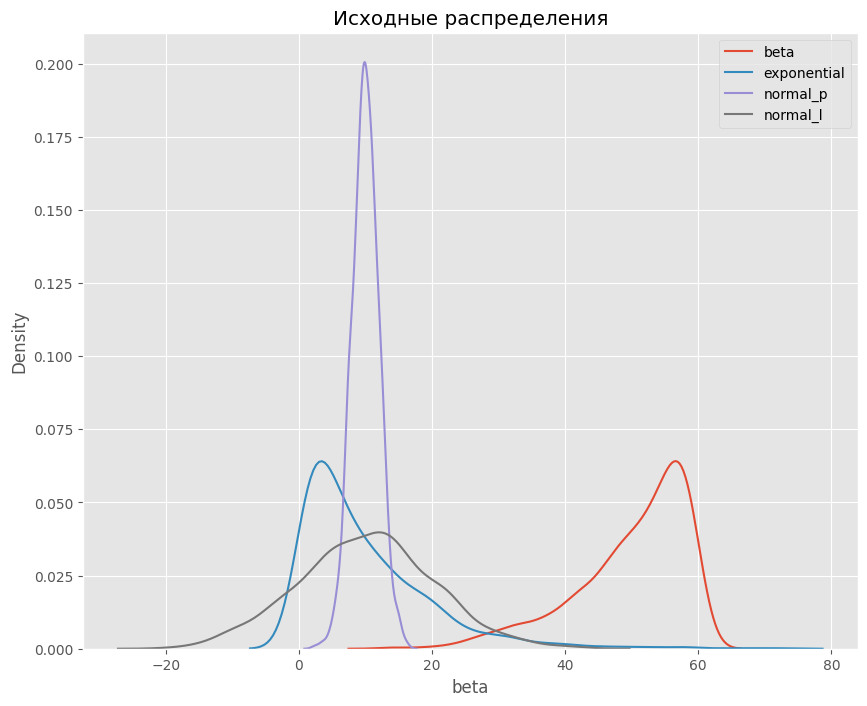

In [70]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(df['beta'], ax=ax1, label ='beta')
sns.kdeplot(df['exponential'], ax=ax1, label ='exponential')
sns.kdeplot(df['normal_p'], ax=ax1, label ='normal_p')
sns.kdeplot(df['normal_l'], ax=ax1, label ='normal_l')
plt.legend()

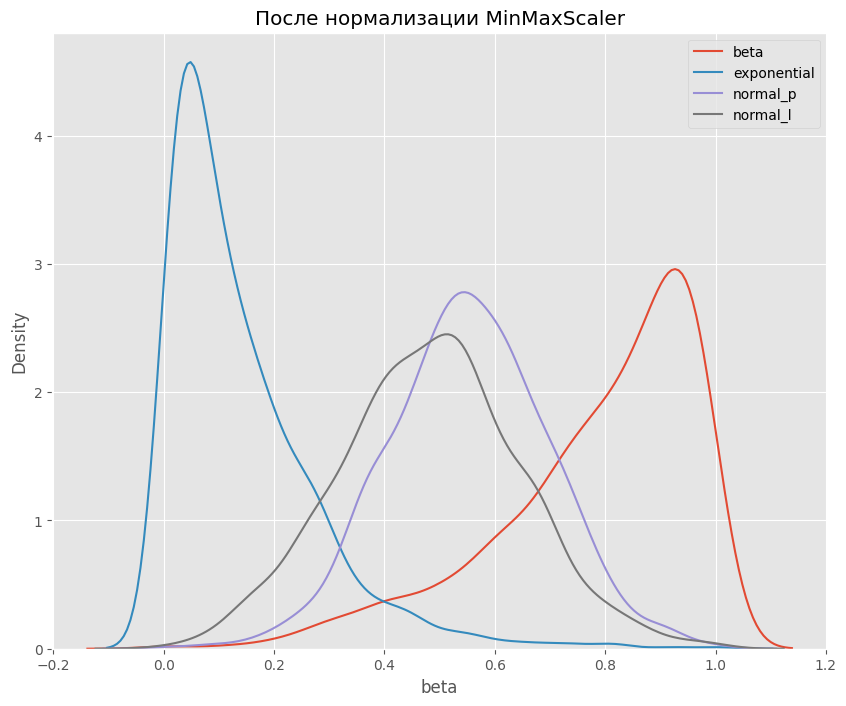

In [71]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
df_mm = mm_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_mm = pd.DataFrame(df_mm, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('После нормализации MinMaxScaler')

sns.kdeplot(df_mm['beta'], ax=ax1, label='beta')
sns.kdeplot(df_mm['exponential'], ax=ax1, label='exponential')
sns.kdeplot(df_mm['normal_p'], ax=ax1, label='normal_p')
sns.kdeplot(df_mm['normal_l'], ax=ax1, label='normal_l')
plt.legend()

In [72]:
df_mm.describe()

,beta,exponential,normal_p,normal_l
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.783981,0.140471,0.551120,0.482297
std,0.183684,0.136450,0.145334,0.163992
min,0.000000,0.000000,0.000000,0.000000
25%,0.692276,0.041266,0.456837,0.375032
50%,0.834120,0.098280,0.550362,0.484741
75%,0.929157,0.196461,0.645864,0.586810
max,1.000000,1.000000,1.000000,1.000000


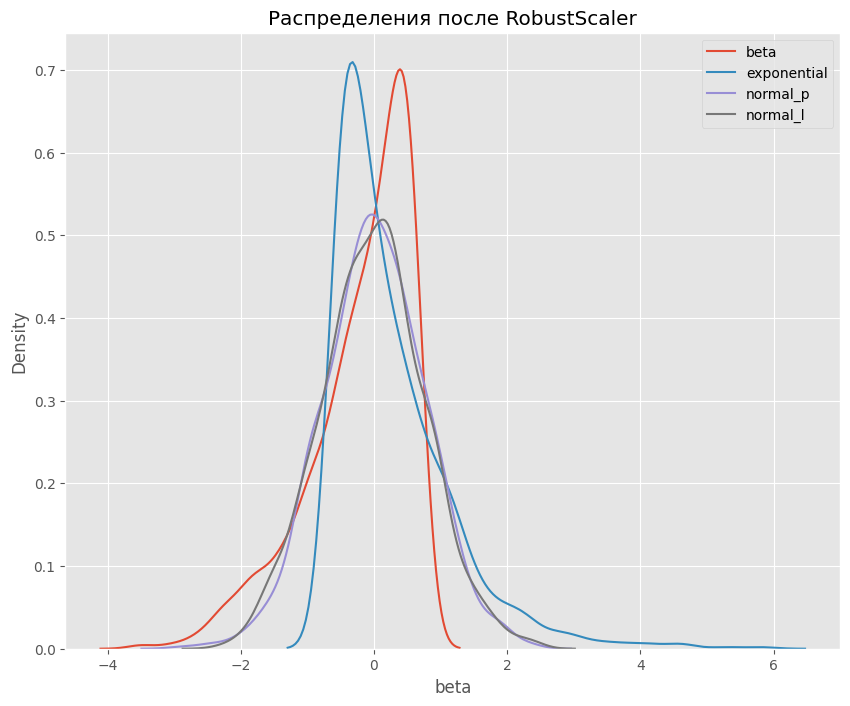

In [73]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
df_r = r_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после RobustScaler')

sns.kdeplot(df_r['beta'], ax=ax1, label='beta')
sns.kdeplot(df_r['exponential'], ax=ax1, label='exponential')
sns.kdeplot(df_r['normal_p'], ax=ax1, label='normal_p')
sns.kdeplot(df_r['normal_l'], ax=ax1, label='normal_l')

plt.legend()


In [74]:
df_r.describe()

,beta,exponential,normal_p,normal_l
count,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000
mean,-2.116639e-01,2.718638e-01,4.011529e-03,-0.011541
std,7.754247e-01,8.792225e-01,7.688570e-01,0.774358
min,-3.521256e+00,-6.332678e-01,-2.911564e+00,-2.288916
25%,-5.987992e-01,-3.673671e-01,-4.947706e-01,-0.518040
50%,3.252607e-16,-4.011548e-17,3.390842e-16,0.000000
75%,4.012008e-01,6.326329e-01,5.052294e-01,0.481960
max,7.002654e-01,5.810261e+00,2.378706e+00,2.433017


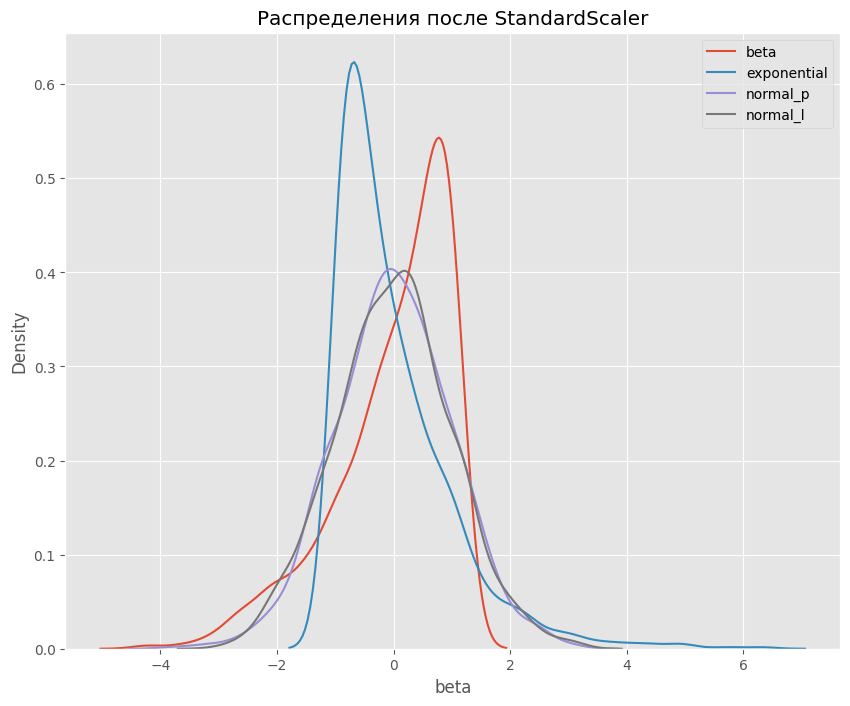

In [75]:
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# кодируем исходный датасет
df_s = s_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_s = pd.DataFrame(df_s, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после StandardScaler')

sns.kdeplot(df_s['beta'], ax=ax1, label='beta')
sns.kdeplot(df_s['exponential'], ax=ax1, label='exponential')
sns.kdeplot(df_s['normal_p'], ax=ax1, label='normal_p')
sns.kdeplot(df_s['normal_l'], ax=ax1, label='normal_l')

plt.legend()

In [76]:
df_s.describe()

,beta,exponential,normal_p,normal_l
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,6.206147e-16,-4.618528e-17,8.013035e-16,-1.704192e-17
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00
min,-4.270238e+00,-1.029983e+00,-3.793988e+00,-2.942457e+00
25%,-4.995057e-01,-7.274049e-01,-6.490566e-01,-6.544169e-01
50%,2.731017e-01,-3.093641e-01,-5.220134e-03,1.491105e-02
75%,7.907555e-01,4.105327e-01,6.522262e-01,6.376219e-01
max,1.176627e+00,6.302351e+00,3.090149e+00,3.158464e+00


In [77]:
data.price.info()

<class 'pandas.core.series.Series'>
Int64Index: 129972 entries, 0 to 129970
Series name: price
Non-Null Count   Dtype  
--------------   -----  
129972 non-null  float64
dtypes: float64(1)
memory usage: 2.0 MB


<AxesSubplot: title={'center': 'Распределение price'}, ylabel='Density'>

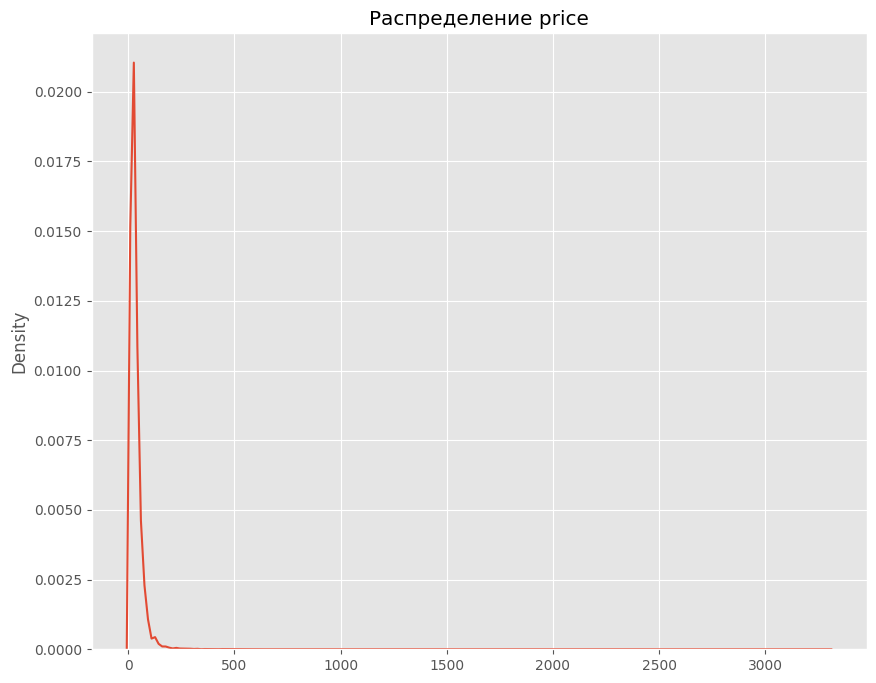

In [78]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределение price')
sns.kdeplot(data['price'].values, ax=ax1)

<AxesSubplot: title={'center': 'Распределение price после RobustScaler'}, ylabel='Density'>

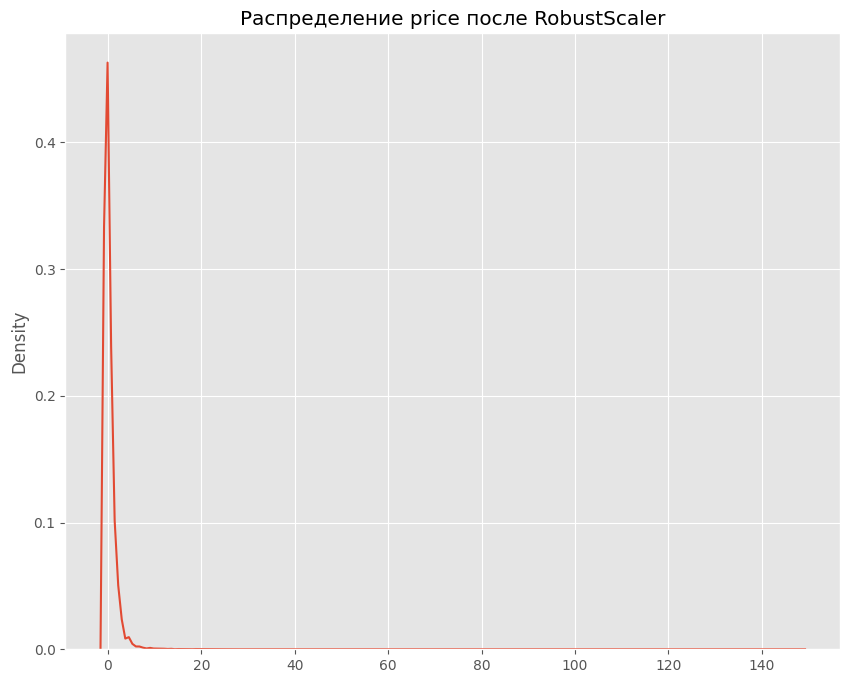

In [79]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
data['price_r'] = r_scaler.fit_transform(data['price'].values.reshape(-1,1))

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределение price после RobustScaler')

sns.kdeplot(data['price_r'].values, ax=ax1)

In [80]:
data['price_r'].describe()

count    129972.000000
mean          0.334693
std           1.798952
min          -1.090909
25%          -0.454545
50%           0.000000
75%           0.545455
max         148.727273
Name: price_r, dtype: float64

In [81]:
int(round(data['price_r'].sum(), 0))

43501

<AxesSubplot: title={'center': 'Распределение price после StandardScaler'}, ylabel='Density'>

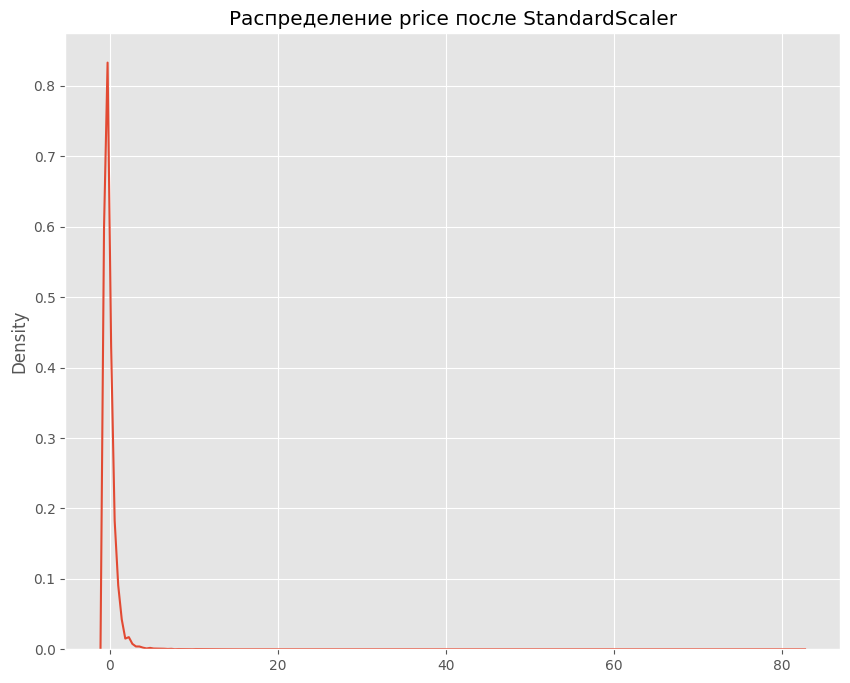

In [82]:
# инициализируем нормализатор RobustScaler
s_scaler = preprocessing.StandardScaler()

# кодируем исходный датасет
data['price_s'] = s_scaler.fit_transform(data['price'].values.reshape(-1,1))

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределение price после StandardScaler')

sns.kdeplot(data['price_s'].values, ax=ax1)

In [83]:
round(data.price_s.iloc[129968], 2)

1.0

Странно, правильным ответом считается -0,14 или 0,14

In [84]:
iris_path = join('dataset', 'iris.csv')
iris = pd.read_csv(iris_path)
iris

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


<AxesSubplot: >

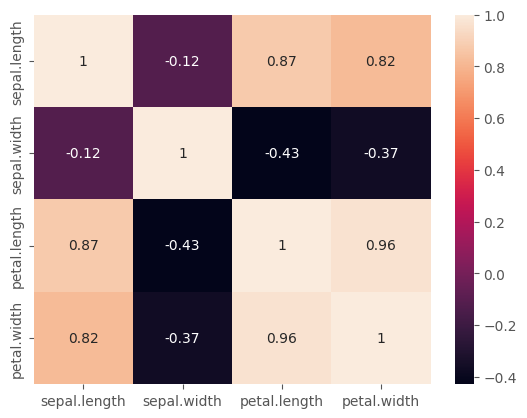

In [85]:
sns.heatmap(iris.corr(), annot=True) # включаем отображение коэффициентов

In [86]:
iris = iris.drop(['petal.width'], axis=1)

In [87]:
iris = iris.drop(['petal.length'], axis=1)
iris

,sepal.length,sepal.width,variety
0,5.1,3.5,Setosa
1,4.9,3.0,Setosa
2,4.7,3.2,Setosa
3,4.6,3.1,Setosa
4,5.0,3.6,Setosa
...,...,...,...
145,6.7,3.0,Virginica
146,6.3,2.5,Virginica
147,6.5,3.0,Virginica
148,6.2,3.4,Virginica


In [89]:
data.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'taster_twitter_handle', 'title', 'variety', 'winery',
       'price_round', 'year', 'is_usa', 'is_france', 'is_italy', 'old_wine',
       'locality', 'population', 'area', 'year_datetime', 'years_diff', 'year',
       'taster_name_Alexander Peartree', 'taster_name_Anna Lee C. Iijima',
       'taster_name_Anne Krebiehl MW', 'taster_name_Carrie Dykes',
       'taster_name_Christina Pickard', 'taster_name_Fiona Adams',
       'taster_name_Jeff Jenssen', 'taster_name_Jim Gordon',
       'taster_name_Joe Czerwinski', 'taster_name_Kerin O’Keefe',
       'taster_name_Lauren Buzzeo', 'taster_name_Matt Kettmann',
       'taster_name_Michael Schachner', 'taster_name_Mike DeSimone',
       'taster_name_Paul Gregutt', 'taster_name_Roger Voss',
       'taster_name_Sean P. Sullivan', 'taster_name_Susan Kostrzewa',
       'taster_name_Virginie Boone', 'taster_name_unknown', 'country_0',
       'country_

In [91]:
data[['price', 'points']].corr().iloc[0,1]

0.4021359197538448

In [92]:
data[['price', 'price_round']].corr().iloc[0,1]

0.9999972843111333

In [93]:
data[['taster_name_1', 'taster_name_2']].corr().iloc[0,1]

KeyError: "None of [Index(['taster_name_1', 'taster_name_2'], dtype='object')] are in the [columns]"

In [95]:
data[['is_italy', 'is_france']].corr().iloc[0,1]

-0.190359125560181

In [99]:
np.abs(data.corr()) < 0.7

,points,price,price_round,is_usa,is_france,is_italy,old_wine,area,years_diff,year,...,country_3,country_4,country_5,taster_twitter_handle_0,taster_twitter_handle_1,taster_twitter_handle_2,taster_twitter_handle_3,taster_twitter_handle_4,price_r,price_s
points,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
price,True,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,False
price_round,True,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,False
is_usa,True,True,True,False,True,True,True,False,True,True,...,True,False,True,True,True,True,True,True,True,True
is_france,True,True,True,True,False,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,True
is_italy,True,True,True,True,True,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
old_wine,True,True,True,True,True,True,False,True,False,True,...,True,True,True,True,True,True,True,True,True,True
area,True,True,True,False,True,True,True,False,True,True,...,True,False,True,True,True,True,True,True,True,True
years_diff,True,True,True,True,True,True,False,True,False,True,...,True,True,True,True,True,True,True,True,True,True
year,True,True,True,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True


KeyError: "['is_usa' 'is_france' 'is_italy' 'price_round' 'area'] not found in axis"

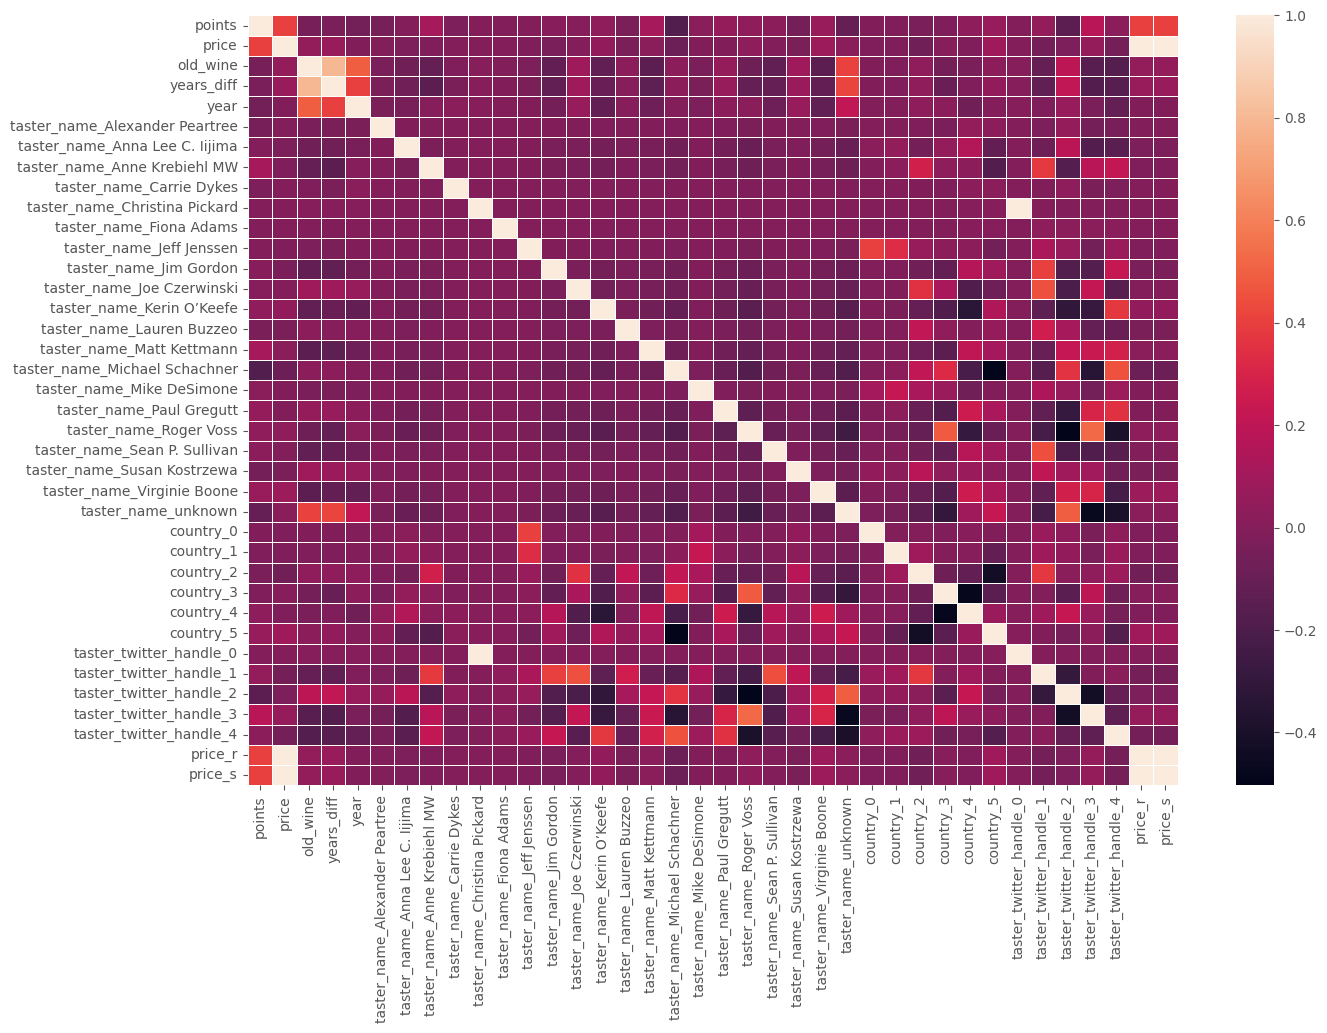

In [101]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data.corr(), annot=False, linewidths=.5, ax=ax)

# Удалим самые сильно скоррелированные пары
data = data.drop(['is_usa', 'is_france', 'is_italy', 'price_round', 'area'], axis=1)

# Проверяем, что сильно скоррелированных признаков не осталось
sns.heatmap(data.corr(), annot=True, linewidths=.5, ax=ax)